In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pandas as pd
from netneurotools import metrics 
import seaborn as sns
import pingouin as pg

from src import data
from scipy import signal

from sklearn import metrics as sk_metrics

%matplotlib widget

!date -I

2024-03-11


In [2]:
def plot_data(data,title=None):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure()
    plt.plot(data);
    plt.title(title)
    plt.show()

def plot_one_roi(data,roi_id,labels,title=None,constants_h=[],constants_v=[]):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure()
    plt.plot(data[:,roi_id])
    for c in constants_h:
        plt.plot([c]*400,color="r")
    for c in constants_v:
        plt.vlines(c, np.min(data), np.max(data),color="r")
    plt.title(labels[roi_id])
    plt.show()

## Load data

### Load pytepfit data

In [3]:
empirical_or_simulated = 'empirical'
pytepfit_path = 'external/pytepfit/'
data_pytepfit = np.load(data.path(f'{pytepfit_path}source_estimates/{empirical_or_simulated}.npz'))
data_pytepfit['ts'].shape

(400, 200)

In [4]:
data_pytepfit['labels'][:10]

array(['7Networks_LH_Cont_Cing_1-lh', '7Networks_LH_Cont_Cing_2-lh',
       '7Networks_LH_Cont_PFCl_1-lh', '7Networks_LH_Cont_PFCl_2-lh',
       '7Networks_LH_Cont_PFCl_3-lh', '7Networks_LH_Cont_PFCl_4-lh',
       '7Networks_LH_Cont_PFCl_5-lh', '7Networks_LH_Cont_PFCl_6-lh',
       '7Networks_LH_Cont_Par_1-lh', '7Networks_LH_Cont_Par_2-lh'],
      dtype='<U40')

In [5]:
data_pytepfit['labels'].shape

(200,)

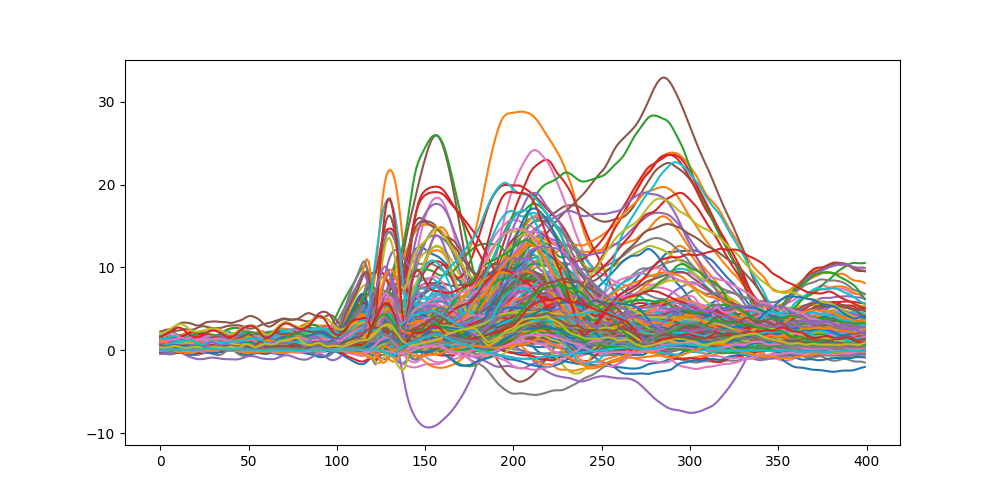

In [6]:
data_ts = data_pytepfit['ts']
plot_data(data_ts)

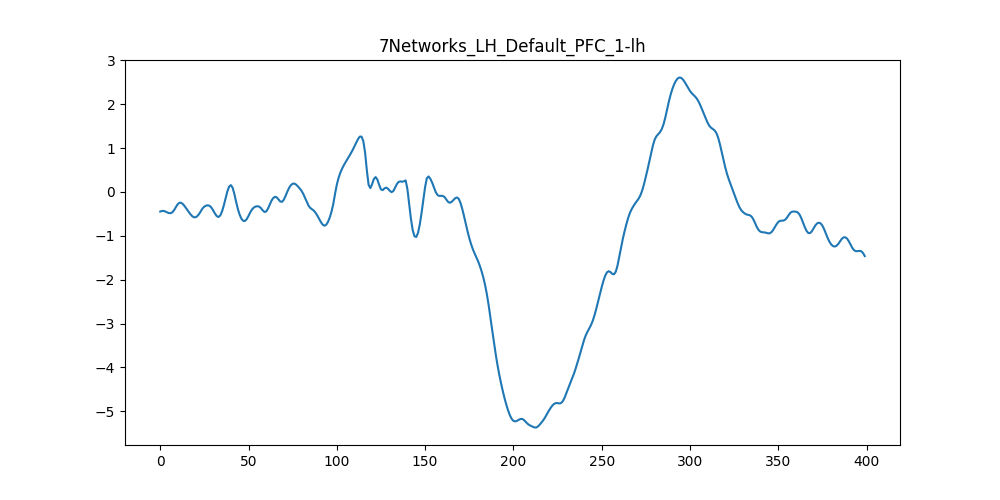

In [7]:
plot_one_roi(data_ts,17,data_pytepfit['labels'])

In [8]:
def peak_analysis(sequence,threshold):
    peaks = signal.find_peaks(sequence,height=threshold)

    if len(peaks[0]) == 0:
        return np.nan, np.nan, np.nan, np.nan

    first_peak_time = peaks[0][0]
    first_peak_height = peaks[1]['peak_heights'][0]
    max_peak_time = peaks[0][np.argmax(peaks[1]['peak_heights'])]
    max_peak_height = np.max(peaks[1]['peak_heights'])

    return first_peak_time, first_peak_height, max_peak_time, max_peak_height

def estimate_auc(seqence, threshold):
    estimate = 0

    for v in seqence:
        if v > threshold:
            estimate += v

    if estimate > 0:
        return estimate

    return None
    

def get_threshold_range(corrected_data,stim_idx):
    maxima = np.max(data_ts[stim_idx:,:],axis=0)
    maxima.sort()

    upper = int(maxima[-5])
    lower = int(np.max(corrected_data[:stim_idx,:]))
    step = int((upper - lower) / 7)

    return range(lower, upper, step)

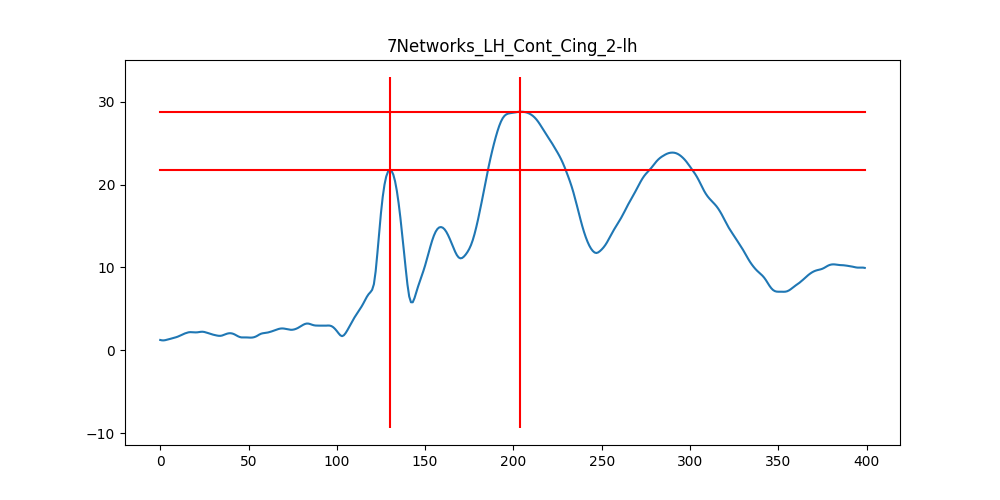

In [9]:
roi_idx = 1

amp_id, amp, amp_h_id, amp_h = peak_analysis(data_ts[:,roi_idx],threshold=5)

plot_one_roi(data_ts,roi_idx,labels=data_pytepfit['labels'],constants_h=[amp,amp_h],constants_v=[amp_id,amp_h_id])

In [10]:
responses = {} 
stim_time = 100

df_responses = pd.DataFrame()

thr_range = get_threshold_range(data_ts,stim_time)


# sklearn.metrics.auc(x, y)

for threshold in thr_range:

    response_df = pd.DataFrame(index=range(200))

    response_df['01-response'] =  np.max(data_ts,axis=0) > threshold

    peak_analysis_results = np.zeros((200,4),dtype=float)
    for i in range(200):
        peak_analysis_results[i] = peak_analysis(data_ts[stim_time:,i],threshold)

    response_df['first_peak'] = peak_analysis_results[:,0]
    response_df['first_peak_time'] = peak_analysis_results[:,1]
    response_df['highest_peak'] = peak_analysis_results[:,2]
    response_df['highest_peak_time'] = peak_analysis_results[:,3]

    response_df['variance'] = np.var(data_ts[stim_time:],axis=0)
    response_df['diff'] = np.max(data_ts[stim_time:],axis=0)-np.min(data_ts[stim_time:],axis=0)

    response_df['AUC'] = np.array([sk_metrics.auc(list(range(len(data_ts[stim_time:,i]))), data_ts[stim_time:,i]) for i in range(200)],dtype=float)
    response_df['AUC_curve_above_thr'] = np.array([sk_metrics.auc(list(range(len(data_ts[stim_time:,i]))), (data_ts[stim_time:,i]-threshold).clip(min=0)) for i in range(200)],dtype=float)
    response_df['mean'] = np.array([np.mean(data_ts[stim_time:,i]) for i in range(200)],dtype=float)
    response_df['power'] = np.array([np.sum(data_ts[stim_time:,i]**2) for i in range(200)],dtype=float)

    for c in ['variance','diff','AUC','AUC_curve_above_thr','mean','power']:
        response_df[c] = np.where(response_df['01-response'],response_df[c],np.nan)

    responses[threshold] = response_df

In [11]:
def prepare_barcode(n_rows,n_cols,title=None):
    pixel_per_bar = 6
    dpi = 100

    fig, ax = plt.subplots(n_rows, 1, figsize=(n_cols * pixel_per_bar / dpi, n_rows/1.5), dpi=dpi, sharex=True)
    fig.suptitle(title)
    fig.subplots_adjust(right=0.7)

    return fig, ax

def plot_one_barcode(ax,data,title=None):

    if not isinstance(data, np.ndarray):
        code = data.to_numpy().reshape(1,-1).astype(float)
    else:
        code = data.reshape(1,-1).astype(float)

    ax.imshow(code, cmap='binary', aspect='auto',
          interpolation='nearest')
    ax.set_title(f"  {title}", loc="right", y=0, ha="left", va="center")
    ax.set_yticks([])

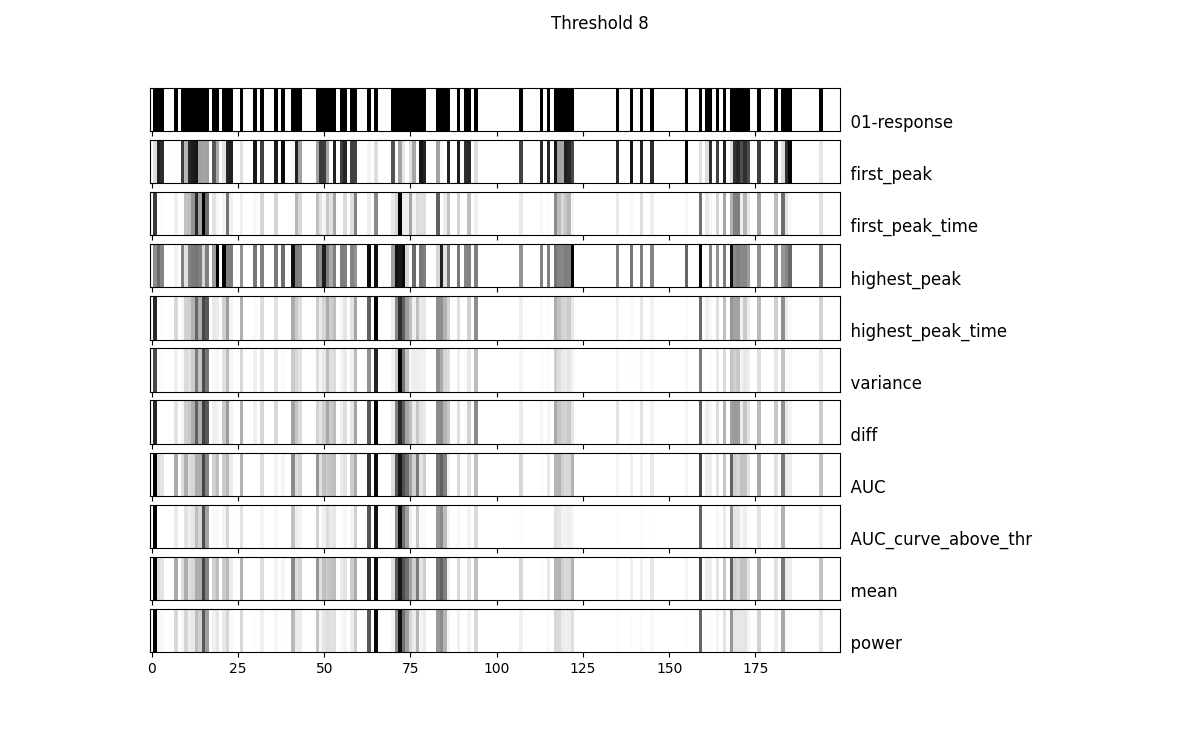

In [12]:
thr = list(responses.keys())[2]

fig, axs = prepare_barcode(len(responses[thr].columns),200,title=f"Threshold {thr}")

for i,c in enumerate(responses[thr].columns):
    plot_one_barcode(axs[i],responses[thr][c],title=c)

In [13]:
stim_locatin = 85 # data_pytepfit['stim_location']

### Load structural (and functional) connectivity data

In [14]:
SC_W, SC_L, _ = data.load_pytepfit_sc()

In [15]:
SC_W_ENIGMA, SC_L_ENIGMA, FC_ENIGMA = data.load_enigma(parcellation="schaefer_200")

/home/katterrina/fi_muni/0_diplomka/src/data.py:59: RuntimeWarning: divide by zero encountered in divide
  SC_L = np.where(SC==0.0,np.nan,1/SC)


In [16]:
SC_W_dom, SC_L_dom, FC_dom = data.load_domhof_for_pytepfit()

(200, 200)


/tmp/ipykernel_63078/3017092137.py:4: RuntimeWarning: divide by zero encountered in log
  axs[0].matshow(np.log(SC_W))


Text(0.5, 1.0, 'Structural connectivity - lengths (log)')

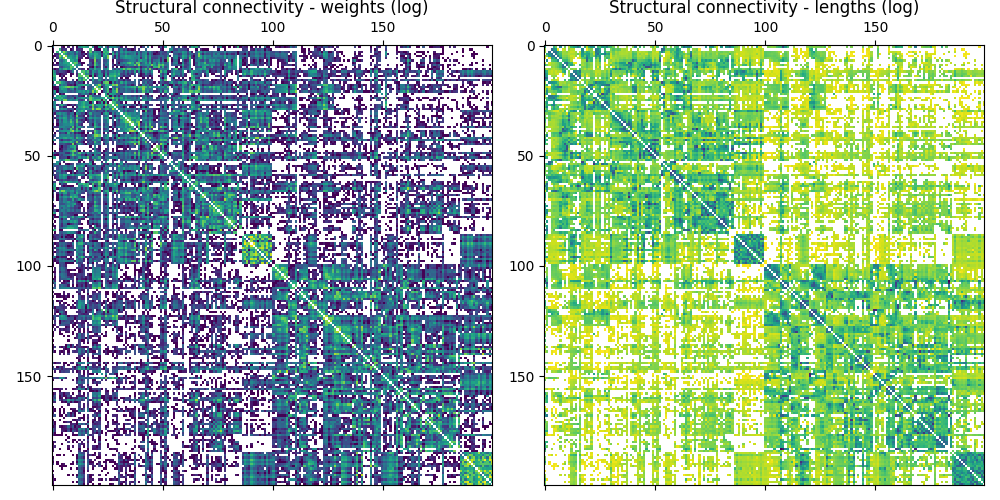

In [17]:
plt.rcParams['figure.figsize'] = [10, 5]

fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].matshow(np.log(SC_W))
axs[0].set_title("Structural connectivity - weights (log)")
axs[1].matshow(np.log(SC_L))
axs[1].set_title("Structural connectivity - lengths (log)")

/tmp/ipykernel_63078/1471994081.py:4: RuntimeWarning: divide by zero encountered in log
  axs[0].matshow(np.log(SC_W_ENIGMA))
/tmp/ipykernel_63078/1471994081.py:4: RuntimeWarning: invalid value encountered in log
  axs[0].matshow(np.log(SC_W_ENIGMA))
/tmp/ipykernel_63078/1471994081.py:6: RuntimeWarning: divide by zero encountered in log
  axs[1].matshow(np.log(FC_ENIGMA))


Text(0.5, 1.0, 'Functional connectivity - ENIGMA (log)')

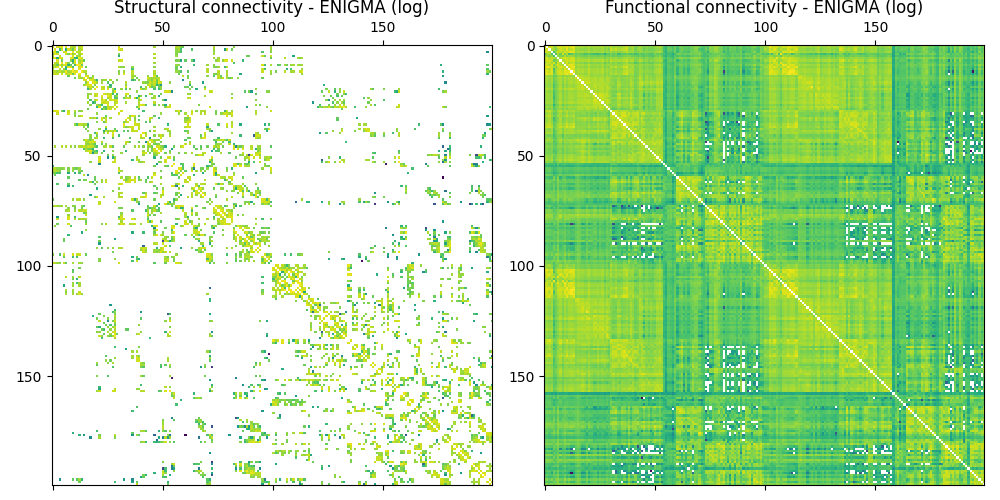

In [18]:
plt.rcParams['figure.figsize'] = [10, 5]

fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].matshow(np.log(SC_W_ENIGMA))
axs[0].set_title("Structural connectivity - ENIGMA (log)")
axs[1].matshow(np.log(FC_ENIGMA))
axs[1].set_title("Functional connectivity - ENIGMA (log)")

Text(0.5, 1.0, 'Structural connectivity Domhof - lengths (log)')

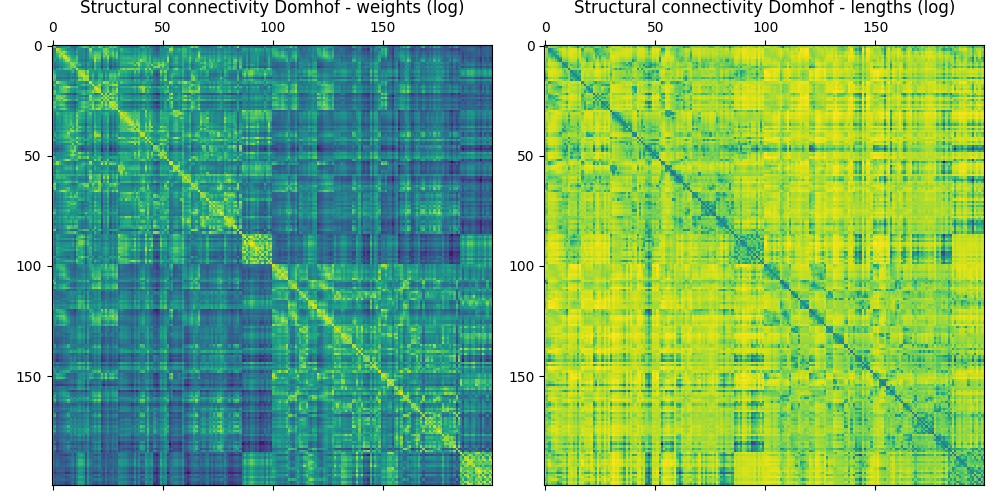

In [19]:
plt.rcParams['figure.figsize'] = [10, 5]

fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].matshow(np.log(SC_W_dom))
axs[0].set_title("Structural connectivity Domhof - weights (log)")
axs[1].matshow(np.log(SC_L_dom))
axs[1].set_title("Structural connectivity Domhof - lengths (log)")

Text(0.5, 1.0, 'ROI distances')

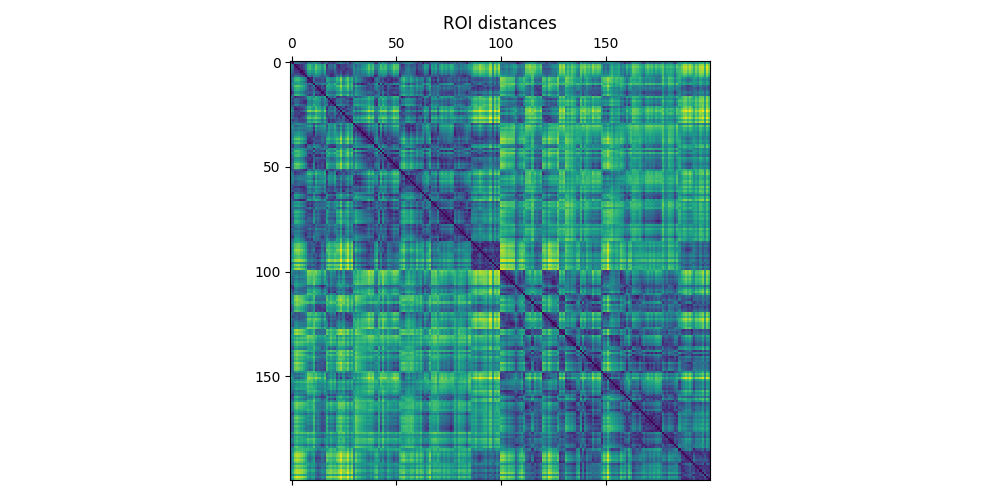

In [21]:
centroids_file = data.path('external/schaefer_parcellation_centroids/ROI_MAPPING_pytepfit.csv')
ED = data.roi_distances_from_centroids(centroids_file,"geom_mne")

fig, axs = plt.subplots(1, 1, tight_layout=True)
axs.matshow(ED)
axs.set_title("ROI distances")

In [22]:
from nilearn import plotting

df = pd.read_csv(centroids_file)
centroids = np.stack(df.geom_mne.apply(lambda x: np.fromstring(x[1:-1], dtype=float, sep=' ')).to_numpy(),axis=0)

In [23]:
dist_to_stim = np.zeros(ED.shape)
dist_to_stim[:,:] = np.nan
dist_to_stim[stim_locatin] = SC_L[stim_locatin] # + 1 # +1 tam je, aby se odlišila 0 a nan; pro SC_L ukáže, v čem by mohl být problém

plot_3D_brain = False

if plot_3D_brain:
    view = plotting.view_connectome(dist_to_stim,centroids,linewidth=4.0,edge_cmap='jet',symmetric_cmap=False,node_color='gray',edge_threshold=1)
    plt.rcParams['figure.figsize'] = [15, 15]
    view.resize(1200,800)
    view # proč k některým vrcholům nevedou čáry? - viz výše, zmatení 0 a nan, vyřeší +1

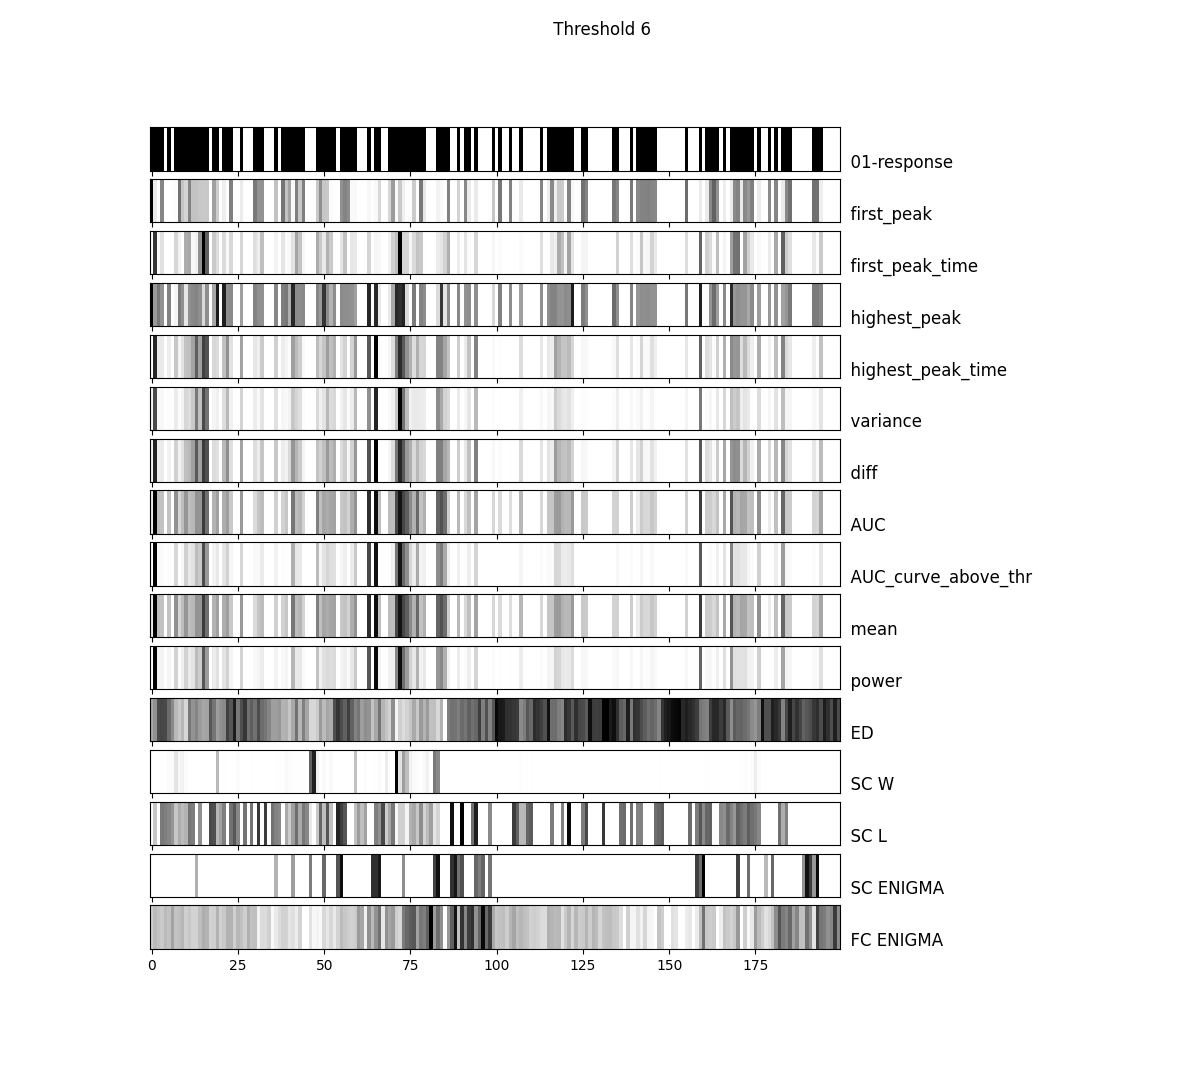

In [25]:
thr = list(responses.keys())[1]
n_of_response_def = len(responses[thr].columns)

fig, axs = prepare_barcode(n_of_response_def+5,200, title = f" Threshold {thr}")



for i,c in enumerate(responses[thr].columns):
    plot_one_barcode(axs[i],responses[thr][c],title=c)

plot_one_barcode(axs[i+1],ED[stim_locatin],title=f"ED")
plot_one_barcode(axs[i+2],SC_W[stim_locatin],title=f"SC W")
plot_one_barcode(axs[i+3],SC_L[stim_locatin],title=f"SC L")
plot_one_barcode(axs[i+4],SC_W_ENIGMA[stim_locatin],title=f"SC ENIGMA")
plot_one_barcode(axs[i+5],FC_ENIGMA[stim_locatin],title=f"FC ENIGMA")

## Correlations

In [27]:
print(spearmanr(SC_W.flatten(),ED.flatten(),nan_policy='omit'))
print(spearmanr(SC_L.flatten(),ED.flatten(),nan_policy='omit'))
print(spearmanr(SC_W.flatten(),SC_L.flatten(),nan_policy='omit'))
print(spearmanr(SC_W.flatten(),SC_W_ENIGMA.flatten(),nan_policy='omit'))
print(spearmanr(FC_ENIGMA.flatten(),ED.flatten(),nan_policy='omit'))
print(spearmanr(FC_ENIGMA.flatten(),FC_dom.flatten(),nan_policy='omit'))
print(spearmanr(SC_W.flatten(),SC_W_dom.flatten(),nan_policy='omit'))

SignificanceResult(statistic=-0.41824980229638786, pvalue=0.0)
SignificanceResult(statistic=0.7157168916070056, pvalue=0.0)
SignificanceResult(statistic=-0.5897822038378862, pvalue=0.0)
SignificanceResult(statistic=0.11278076220131807, pvalue=2.3151871358310112e-113)
SignificanceResult(statistic=-0.05005037205827114, pvalue=1.2959319314785495e-23)
SignificanceResult(statistic=0.11034390789394441, pvalue=1.4323054003331888e-108)
SignificanceResult(statistic=0.8344117385340916, pvalue=0.0)


In [ ]:
def plot_result(result_df,title=None):
    df_plot = result_df.reset_index().pivot(columns='level_0',index='Y',values='r')
    df_plot_p = result_df.reset_index().pivot(columns='level_0',index='Y',values='p-unc')

    plt.figure()
    ax = sns.heatmap(df_plot.where(df_plot_p < 0.05), annot=True,center=0,cmap='seismic',vmin=-1, vmax=1)
    ax.set_title(title)
    ax.set(xlabel='threshold')

    plt.savefig(f'../figures/correlations/{empirical_or_simulated}/{title}.png')
    plt.show()


def coor_with_response(X,title=None):
    s = pd.Series(X[stim_locatin])

    dict_by_thr = dict()

    for threshold in thr_range:
        df = responses[threshold]
        df["tested"] = s
        stat_pg = pg.pairwise_corr(df,columns=["tested"],method="spearman").round(3)
        dict_by_thr[threshold] = stat_pg[["Y","r","p-unc"]]

    results = pd.concat(dict_by_thr.values(), keys=dict_by_thr.keys())
    plot_result(results,title=title)

    return results

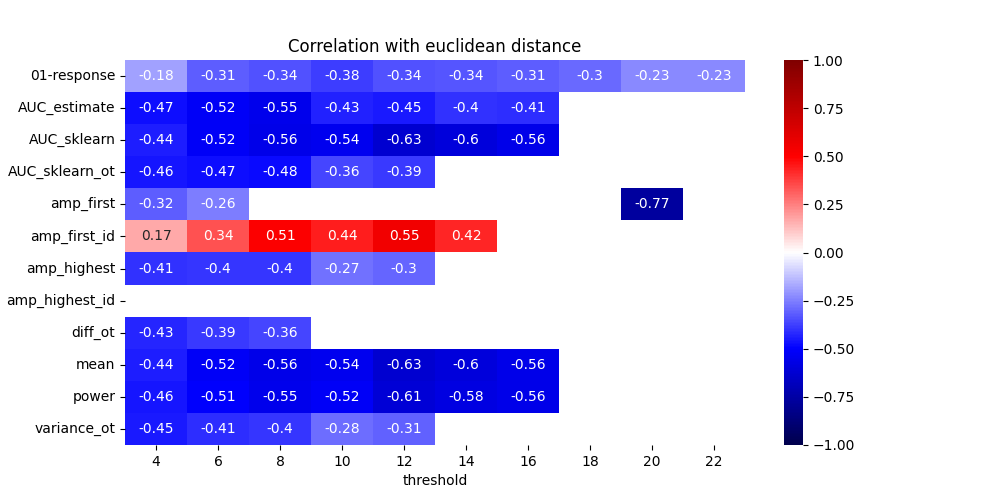

Y      r  p-unc
4  0      01-response -0.183  0.009
   1      amp_highest -0.405  0.000
   2        amp_first -0.318  0.000
   3     amp_first_id  0.171  0.031
   4   amp_highest_id  0.089  0.270
...               ...    ...    ...
22 7     AUC_estimate -0.517  0.154
   8      AUC_sklearn -0.133  0.732
   9   AUC_sklearn_ot -0.483  0.187
   10            mean -0.133  0.732
   11           power -0.133  0.732

[120 rows x 3 columns]

In [ ]:
coor_with_response(ED,"Correlation with euclidean distance")

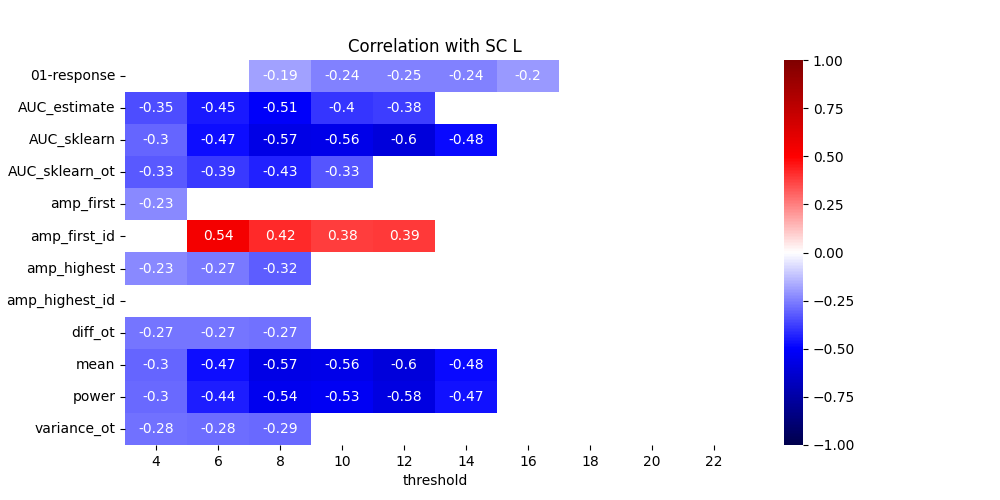

Y      r  p-unc
4  0      01-response -0.183  0.052
   1      amp_highest -0.234  0.026
   2        amp_first -0.229  0.029
   3     amp_first_id  0.172  0.100
   4   amp_highest_id  0.146  0.167
...               ...    ...    ...
22 7     AUC_estimate -0.500  0.391
   8      AUC_sklearn  0.100  0.873
   9   AUC_sklearn_ot -0.100  0.873
   10            mean  0.100  0.873
   11           power  0.100  0.873

[120 rows x 3 columns]

In [ ]:
coor_with_response(SC_L,"Correlation with SC L") 


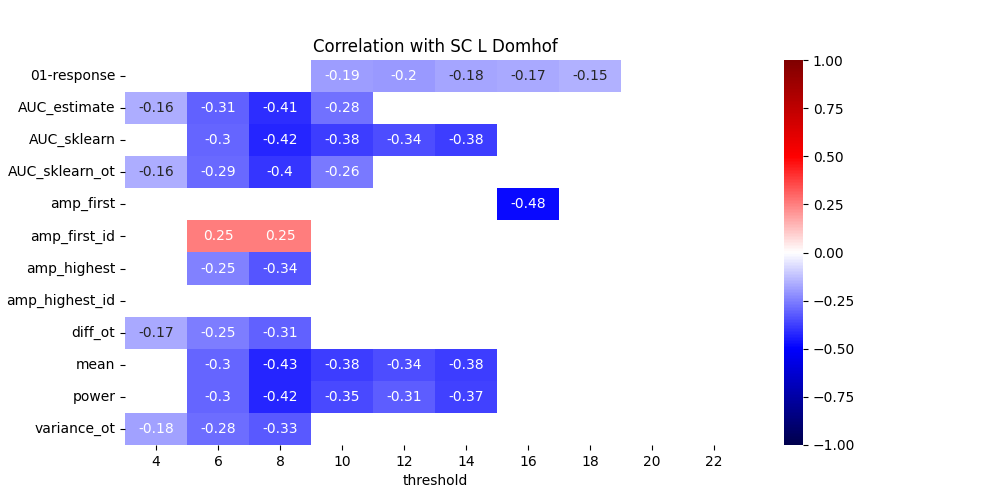

Y      r  p-unc
4  0      01-response -0.071  0.318
   1      amp_highest -0.138  0.085
   2        amp_first -0.046  0.571
   3     amp_first_id  0.094  0.237
   4   amp_highest_id -0.026  0.747
...               ...    ...    ...
22 7     AUC_estimate -0.400  0.286
   8      AUC_sklearn -0.067  0.865
   9   AUC_sklearn_ot -0.083  0.831
   10            mean -0.067  0.865
   11           power -0.067  0.865

[120 rows x 3 columns]

In [ ]:
coor_with_response(SC_L_dom,"Correlation with SC L Domhof") 

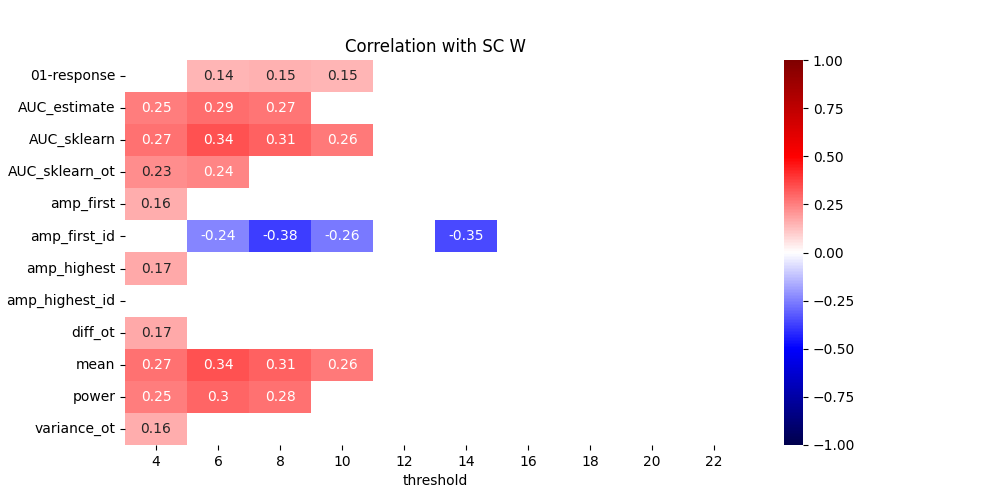

Y      r  p-unc
4  0      01-response  0.099  0.165
   1      amp_highest  0.171  0.032
   2        amp_first  0.164  0.041
   3     amp_first_id -0.148  0.063
   4   amp_highest_id -0.116  0.147
...               ...    ...    ...
22 7     AUC_estimate  0.374  0.321
   8      AUC_sklearn  0.313  0.412
   9   AUC_sklearn_ot  0.279  0.468
   10            mean  0.313  0.412
   11           power  0.313  0.412

[120 rows x 3 columns]

In [ ]:
coor_with_response(SC_W,"Correlation with SC W") 

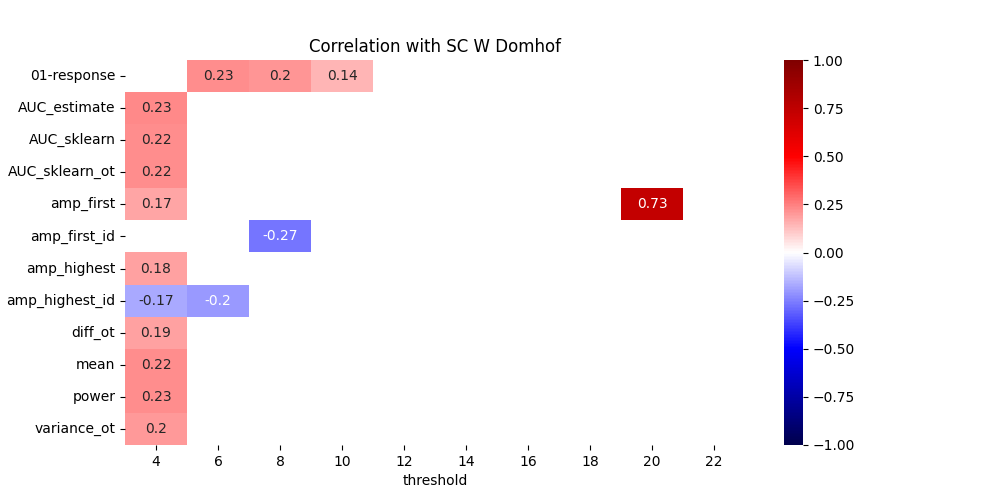

Y      r  p-unc
4  0      01-response  0.115  0.105
   1      amp_highest  0.182  0.023
   2        amp_first  0.173  0.030
   3     amp_first_id -0.104  0.192
   4   amp_highest_id -0.168  0.035
...               ...    ...    ...
22 7     AUC_estimate  0.333  0.381
   8      AUC_sklearn  0.133  0.732
   9   AUC_sklearn_ot  0.400  0.286
   10            mean  0.133  0.732
   11           power  0.133  0.732

[120 rows x 3 columns]

In [ ]:
coor_with_response(SC_W_dom,"Correlation with SC W Domhof") 

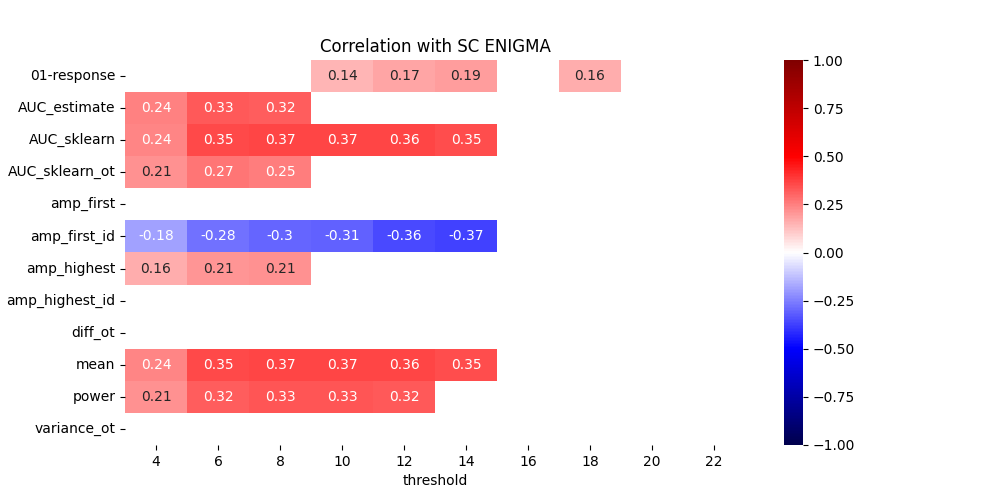

Y      r  p-unc
4  0      01-response  0.060  0.396
   1      amp_highest  0.158  0.048
   2        amp_first  0.056  0.483
   3     amp_first_id -0.184  0.020
   4   amp_highest_id -0.129  0.107
...               ...    ...    ...
22 7     AUC_estimate  0.274  0.476
   8      AUC_sklearn -0.046  0.907
   9   AUC_sklearn_ot  0.068  0.861
   10            mean -0.046  0.907
   11           power -0.046  0.907

[120 rows x 3 columns]

In [ ]:
coor_with_response(SC_W_ENIGMA,"Correlation with SC ENIGMA") 

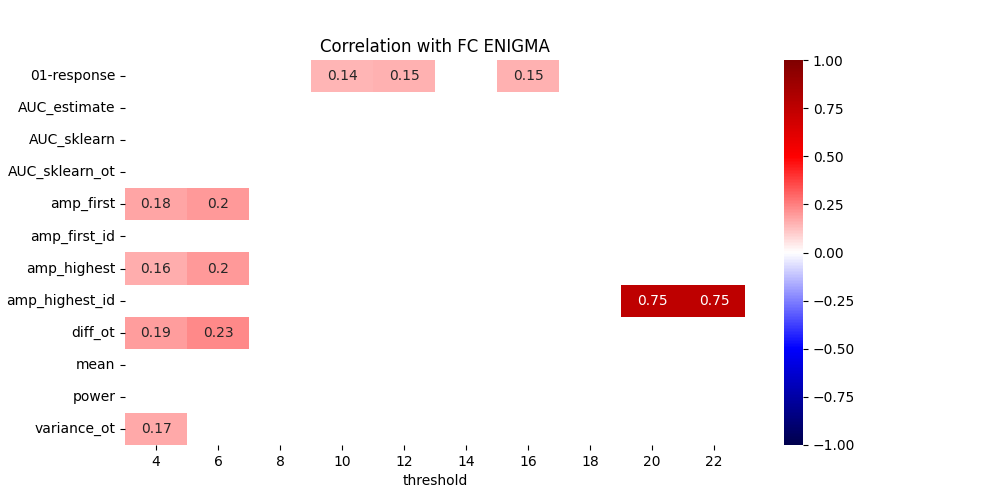

Y      r  p-unc
4  0      01-response  0.012  0.869
   1      amp_highest  0.161  0.044
   2        amp_first  0.179  0.025
   3     amp_first_id  0.109  0.171
   4   amp_highest_id -0.040  0.616
...               ...    ...    ...
22 7     AUC_estimate  0.000  1.000
   8      AUC_sklearn -0.017  0.966
   9   AUC_sklearn_ot -0.067  0.865
   10            mean -0.017  0.966
   11           power -0.017  0.966

[120 rows x 3 columns]

In [ ]:
coor_with_response(FC_dom,"Correlation with FC Domhof") 

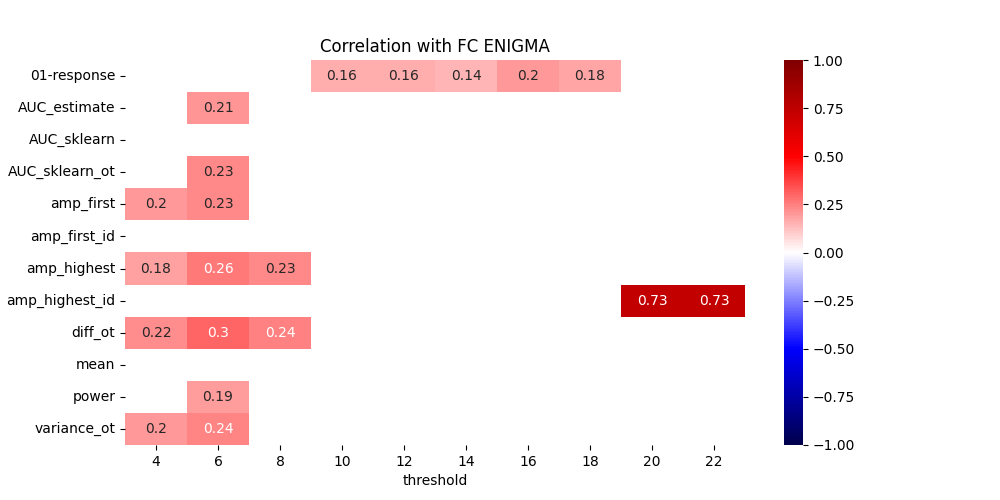

Y      r  p-unc
4  0      01-response -0.013  0.858
   1      amp_highest  0.182  0.022
   2        amp_first  0.201  0.012
   3     amp_first_id  0.137  0.084
   4   amp_highest_id  0.003  0.972
...               ...    ...    ...
22 7     AUC_estimate  0.017  0.966
   8      AUC_sklearn  0.000  1.000
   9   AUC_sklearn_ot -0.017  0.966
   10            mean  0.000  1.000
   11           power  0.000  1.000

[120 rows x 3 columns]

In [ ]:
coor_with_response(FC_ENIGMA,"Correlation with FC ENIGMA") 

### TODO: Projít všechna místa, kde ignoruji warningy!

/tmp/ipykernel_49003/3752043138.py:3: RuntimeWarning: divide by zero encountered in divide
  shorest_path_eff = np.divide(1,shorest_paths)


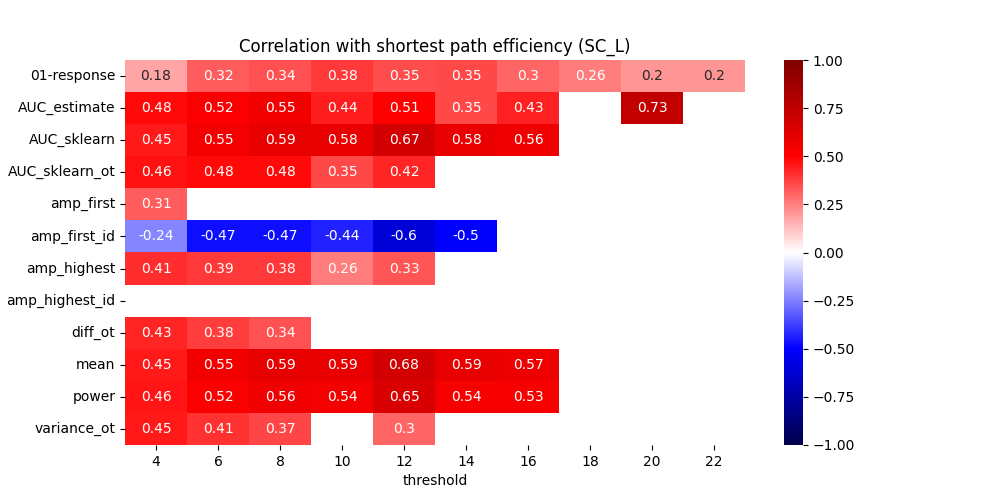

Y      r  p-unc
4  0      01-response  0.178  0.012
   1      amp_highest  0.407  0.000
   2        amp_first  0.313  0.000
   3     amp_first_id -0.242  0.002
   4   amp_highest_id -0.117  0.143
...               ...    ...    ...
22 7     AUC_estimate  0.550  0.125
   8      AUC_sklearn  0.550  0.125
   9   AUC_sklearn_ot  0.317  0.406
   10            mean  0.550  0.125
   11           power  0.550  0.125

[120 rows x 3 columns]

In [ ]:
# shortest path efficiency
shorest_paths,_ = metrics.distance_wei_floyd(SC_L)
shorest_path_eff = np.divide(1,shorest_paths)

coor_with_response(shorest_path_eff,"Correlation with shortest path efficiency (SC_L)")

/tmp/ipykernel_49003/2649094724.py:3: RuntimeWarning: divide by zero encountered in divide
  shorest_path_eff = np.divide(1,shorest_paths)


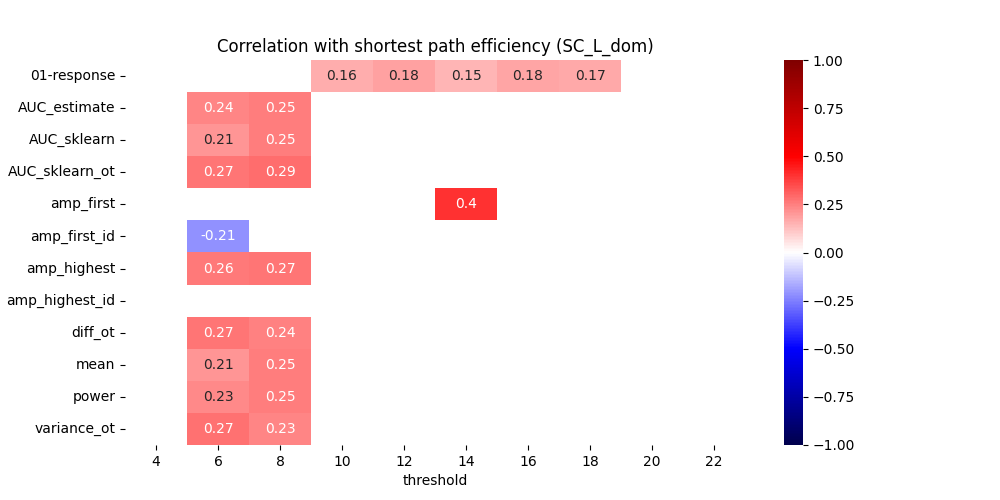

Y      r  p-unc
4  0      01-response  0.086  0.228
   1      amp_highest  0.105  0.193
   2        amp_first  0.083  0.299
   3     amp_first_id -0.061  0.448
   4   amp_highest_id -0.045  0.578
...               ...    ...    ...
22 7     AUC_estimate  0.600  0.088
   8      AUC_sklearn  0.300  0.433
   9   AUC_sklearn_ot  0.317  0.406
   10            mean  0.300  0.433
   11           power  0.300  0.433

[120 rows x 3 columns]

In [ ]:
# shortest path efficiency
shorest_paths,_ = metrics.distance_wei_floyd(SC_L_dom)
shorest_path_eff = np.divide(1,shorest_paths)

coor_with_response(shorest_path_eff,"Correlation with shortest path efficiency (SC_L_dom)")

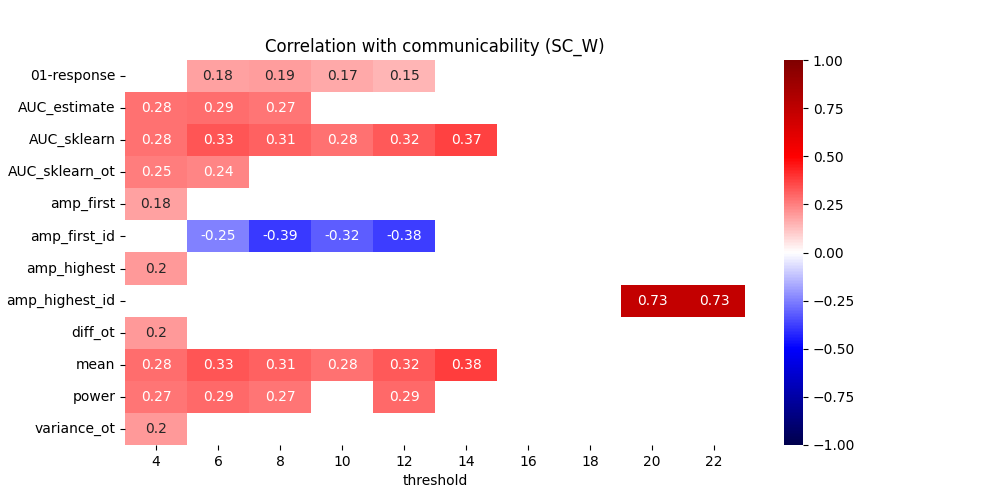

Y      r  p-unc
4  0      01-response  0.126  0.076
   1      amp_highest  0.197  0.013
   2        amp_first  0.185  0.021
   3     amp_first_id -0.148  0.062
   4   amp_highest_id -0.149  0.063
...               ...    ...    ...
22 7     AUC_estimate  0.233  0.546
   8      AUC_sklearn  0.283  0.460
   9   AUC_sklearn_ot  0.133  0.732
   10            mean  0.283  0.460
   11           power  0.283  0.460

[120 rows x 3 columns]

In [ ]:
com = metrics.communicability_wei(SC_W)
coor_with_response(com,title="Correlation with communicability (SC_W)")

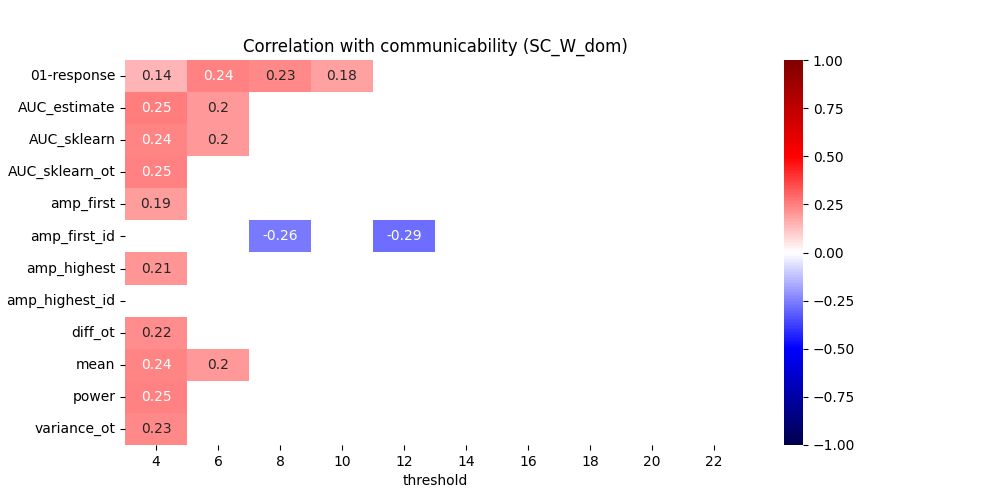

Y      r  p-unc
4  0      01-response  0.143  0.043
   1      amp_highest  0.210  0.008
   2        amp_first  0.189  0.018
   3     amp_first_id -0.091  0.253
   4   amp_highest_id -0.134  0.094
...               ...    ...    ...
22 7     AUC_estimate  0.350  0.356
   8      AUC_sklearn  0.250  0.516
   9   AUC_sklearn_ot  0.383  0.308
   10            mean  0.250  0.516
   11           power  0.250  0.516

[120 rows x 3 columns]

In [ ]:
com = metrics.communicability_wei(SC_W_dom)
coor_with_response(com,title="Correlation with communicability (SC_W_dom)")

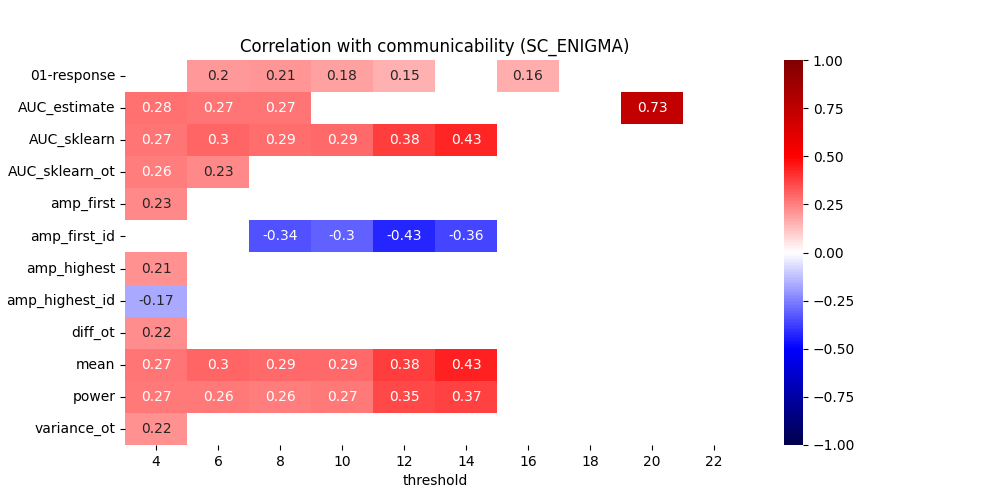

Y      r  p-unc
4  0      01-response  0.135  0.057
   1      amp_highest  0.215  0.007
   2        amp_first  0.227  0.004
   3     amp_first_id -0.092  0.249
   4   amp_highest_id -0.167  0.036
...               ...    ...    ...
22 7     AUC_estimate  0.583  0.099
   8      AUC_sklearn  0.583  0.099
   9   AUC_sklearn_ot  0.417  0.265
   10            mean  0.583  0.099
   11           power  0.583  0.099

[120 rows x 3 columns]

In [ ]:
com = metrics.communicability_wei(SC_W_ENIGMA)
coor_with_response(com,title="Correlation with communicability (SC_ENIGMA)")

/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:553: RuntimeWarning: divide by zero encountered in log2
  SI[i, j] = -np.log2(np.prod(pr_step_ff))
/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:554: RuntimeWarning: divide by zero encountered in log2
  SI[j, i] = -np.log2(np.prod(pr_step_bk))


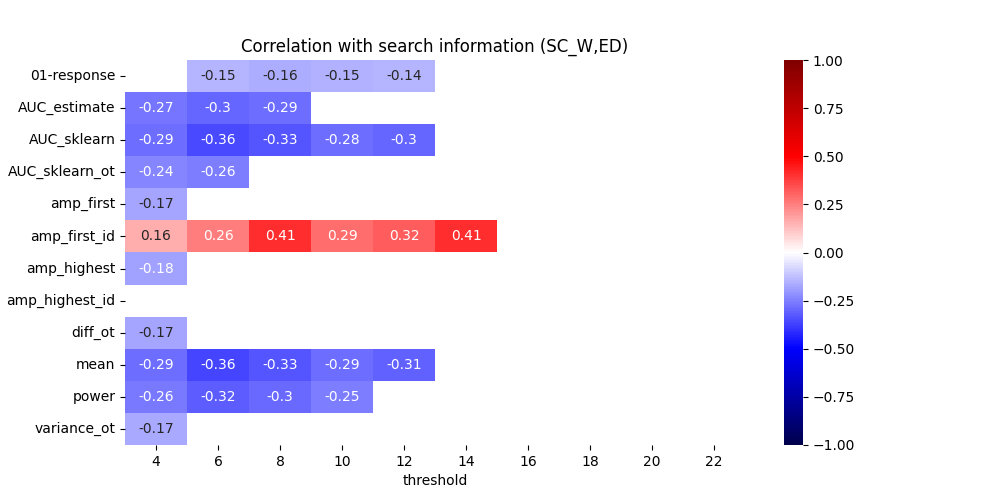

Y      r  p-unc
4  0      01-response -0.102  0.152
   1      amp_highest -0.181  0.024
   2        amp_first -0.172  0.031
   3     amp_first_id  0.158  0.047
   4   amp_highest_id  0.126  0.117
...               ...    ...    ...
22 7     AUC_estimate -0.374  0.321
   8      AUC_sklearn -0.313  0.412
   9   AUC_sklearn_ot -0.279  0.468
   10            mean -0.313  0.412
   11           power -0.313  0.412

[120 rows x 3 columns]

In [ ]:
SI = metrics.search_information(SC_W,ED) # má tu být ED?

coor_with_response(SI, title="Correlation with search information (SC_W,ED)")

/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:553: RuntimeWarning: divide by zero encountered in log2
  SI[i, j] = -np.log2(np.prod(pr_step_ff))
/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:554: RuntimeWarning: divide by zero encountered in log2
  SI[j, i] = -np.log2(np.prod(pr_step_bk))
/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:553: RuntimeWarning: invalid value encountered in log2
  SI[i, j] = -np.log2(np.prod(pr_step_ff))
/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:554: RuntimeWarning: invalid value encountered in log2
  SI[j, i] = -np.log2(np.prod(pr_step_bk))


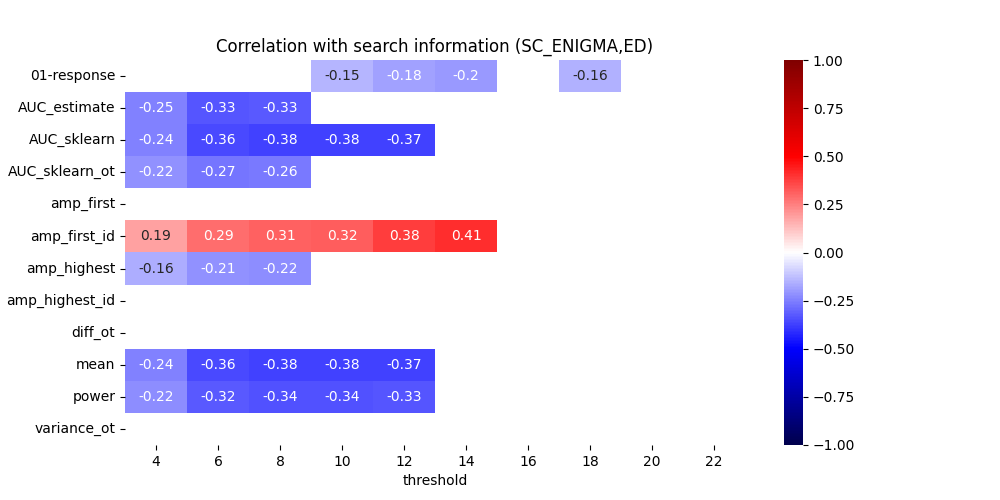

Y      r  p-unc
4  0      01-response -0.061  0.390
   1      amp_highest -0.161  0.044
   2        amp_first -0.059  0.462
   3     amp_first_id  0.187  0.018
   4   amp_highest_id  0.132  0.101
...               ...    ...    ...
22 7     AUC_estimate -0.274  0.476
   8      AUC_sklearn  0.046  0.907
   9   AUC_sklearn_ot -0.068  0.861
   10            mean  0.046  0.907
   11           power  0.046  0.907

[120 rows x 3 columns]

In [ ]:
SI = metrics.search_information(SC_W_ENIGMA,ED) # má tu být ED?

coor_with_response(SI, title="Correlation with search information (SC_ENIGMA,ED)")

/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:780: RuntimeWarning: divide by zero encountered in divide
  E_diff = np.divide(1, mfpt)
/tmp/ipykernel_49003/1939914631.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


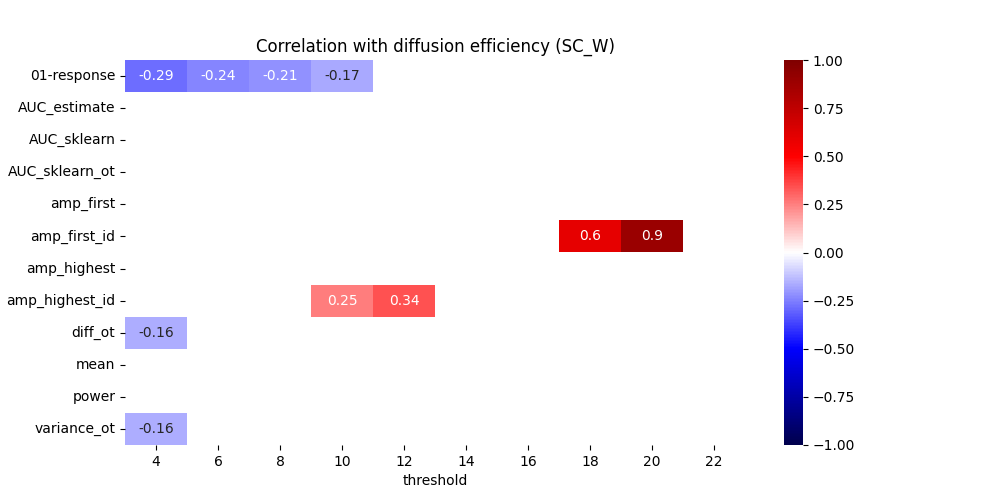

Y      r  p-unc
4  0      01-response -0.286  0.000
   1      amp_highest -0.111  0.167
   2        amp_first -0.050  0.532
   3     amp_first_id  0.088  0.270
   4   amp_highest_id  0.058  0.472
...               ...    ...    ...
22 7     AUC_estimate -0.133  0.732
   8      AUC_sklearn -0.133  0.732
   9   AUC_sklearn_ot -0.017  0.966
   10            mean -0.133  0.732
   11           power -0.133  0.732

[120 rows x 3 columns]

In [ ]:
# https://netneurolab.github.io/netneurotools/_modules/netneurotools/metrics.html#diffusion_efficiency
diffusion = metrics.diffusion_efficiency(SC_W)[1] # tahle funkce určitě má dostat SC, a ne délky L

coor_with_response(diffusion, title="Correlation with diffusion efficiency (SC_W)")

/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:780: RuntimeWarning: divide by zero encountered in divide
  E_diff = np.divide(1, mfpt)


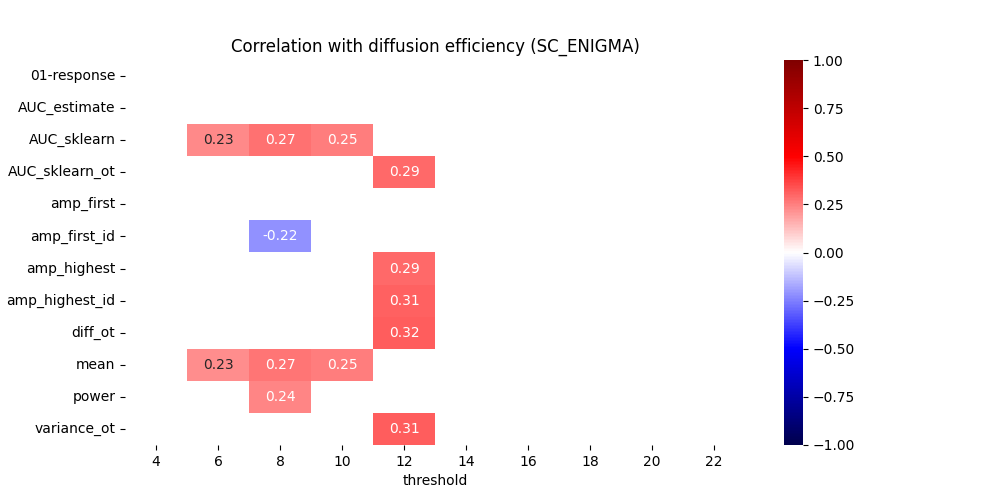

Y      r  p-unc
4  0      01-response -0.127  0.073
   1      amp_highest  0.007  0.932
   2        amp_first  0.047  0.562
   3     amp_first_id -0.031  0.702
   4   amp_highest_id  0.020  0.805
...               ...    ...    ...
22 7     AUC_estimate -0.200  0.606
   8      AUC_sklearn  0.183  0.637
   9   AUC_sklearn_ot -0.217  0.576
   10            mean  0.183  0.637
   11           power  0.183  0.637

[120 rows x 3 columns]

In [ ]:
# https://netneurolab.github.io/netneurotools/_modules/netneurotools/metrics.html#diffusion_efficiency
diffusion = metrics.diffusion_efficiency(SC_W_ENIGMA)[1] # tahle funkce určitě má dostat SC, a ne délky L

coor_with_response(diffusion, title="Correlation with diffusion efficiency (SC_ENIGMA)")

/tmp/ipykernel_49003/3709486484.py:3: RuntimeWarning: divide by zero encountered in divide
  nav_eff = np.divide(1,nav_paths)


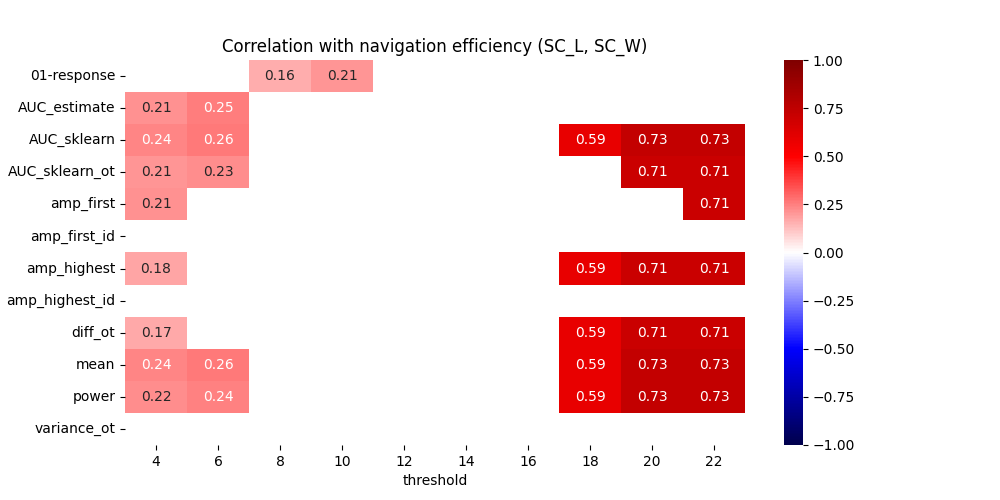

Y      r  p-unc
4  0      01-response  0.045  0.525
   1      amp_highest  0.179  0.025
   2        amp_first  0.214  0.007
   3     amp_first_id -0.088  0.272
   4   amp_highest_id -0.012  0.885
...               ...    ...    ...
22 7     AUC_estimate  0.639  0.064
   8      AUC_sklearn  0.730  0.025
   9   AUC_sklearn_ot  0.707  0.033
   10            mean  0.730  0.025
   11           power  0.730  0.025

[120 rows x 3 columns]

In [ ]:
# tady té funkci možná dávám špatný vstup?
_,_,nav_paths,_,_ = metrics.navigation_wu(SC_L, SC_W)
nav_eff = np.divide(1,nav_paths)

coor_with_response(nav_eff, title="Correlation with navigation efficiency (SC_L, SC_W)")

/tmp/ipykernel_49003/1859258809.py:3: RuntimeWarning: divide by zero encountered in divide
  nav_eff = np.divide(1,nav_paths)


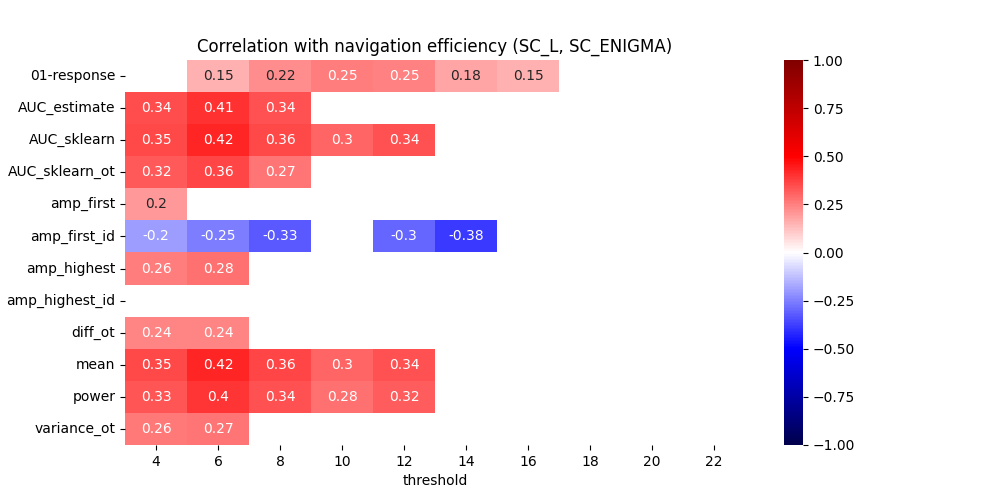

Y      r  p-unc
4  0      01-response  0.079  0.264
   1      amp_highest  0.257  0.001
   2        amp_first  0.201  0.011
   3     amp_first_id -0.195  0.014
   4   amp_highest_id -0.029  0.717
...               ...    ...    ...
22 7     AUC_estimate  0.465  0.207
   8      AUC_sklearn  0.248  0.521
   9   AUC_sklearn_ot  0.406  0.278
   10            mean  0.248  0.521
   11           power  0.248  0.521

[120 rows x 3 columns]

In [ ]:
# tady té funkci možná dávám špatný vstup?
_,_,nav_paths,_,_ = metrics.navigation_wu(SC_L, SC_W_ENIGMA)
nav_eff = np.divide(1,nav_paths)

coor_with_response(nav_eff, title="Correlation with navigation efficiency (SC_L, SC_ENIGMA)")